# T+5 Prediction



## Set X,y data. (normalized)

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ExpSineSquared,ConstantKernel as C
from sklearn.metrics import mean_squared_error
import joblib
from datetime import datetime, timedelta

# Read data
df = pd.read_csv(r'Weekly_Average_FoodWaste.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define the chosen category for plotting
chosen_category = 'Carbohydrates'

filtered_data = df[['Date',chosen_category]]

split_ratio = 0.97 # 0.93 = 2 points (test data)
split_index = int(len(filtered_data) * split_ratio)
df_train = filtered_data[:split_index+1]
df_test = filtered_data[split_index:]

start = filtered_data['Date'].min()
end = filtered_data['Date'].max()
range_datetime = (end - start).days
print(range_datetime)

reference_date = datetime(2023, 1, 1)
X = (filtered_data['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime


# Normalize train data 
X_train = (df_train['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
y_train = df_train[chosen_category].values.reshape(-1, 1) / np.max(filtered_data[chosen_category])
#y_train = df_train[chosen_category]

# Normalize test data
X_test = (df_test['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
y_test = df_test[chosen_category].values.reshape(-1, 1) / np.max(df_train[chosen_category])
#y_test = df_test[chosen_category] #using normalize_y=true in sklearn

print(f'{X_train.shape},{y_train.shape},{X_test.shape},{y_test.shape}')

259
(37, 1),(37, 1),(2, 1),(2, 1)


## Fit

In [2]:
def display_optimized_model(kernel_input,model):
    print(f"Initial: {kernel_input}\nOptimum: {model.kernel_} ")
    print(f"Negative Log-Marginal-Likelihood evaluate at kernel_theta :{model.kernel_.theta} -->{model.log_marginal_likelihood(model.kernel_.theta)}")
    print('---------------------------------')
    print('model kernel',model.kernel_)
    print("\nkernel_.theta is actually the log(theta). Only when you do exp(kernel_.theta), you will get back the same values as model.kernel_ ")
    exp_theta = np.exp(model.kernel_.theta)
    print(f"\nexp kernel theta :{exp_theta}")


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Gaussian stuff starts here 

# Define different kernels
kernel_rbf = RBF(length_scale=20 ) #+ WhiteKernel(noise_level=10)
kernel_matern = Matern(length_scale=2.4, nu=5 ) #length_scale=2, nu=1.05, sigma=1 / length_scale=2.4, nu=1.03, sigma=2 / length_scale=2.4, nu=5 , split = 0.97
kernel_combined = kernel_rbf + kernel_matern


# Create Gaussian Process with different kernels
model = GaussianProcessRegressor(kernel=kernel_combined, n_restarts_optimizer=10)


# Fit the Gaussian Processes for the current category
model.fit(X_train, y_train)
model_params = model.get_params()


display_optimized_model(kernel_combined,model)

c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Initial: RBF(length_scale=20) + Matern(length_scale=2.4, nu=5)
Optimum: RBF(length_scale=9.69e+04) + Matern(length_scale=0.0389, nu=5) 
Negative Log-Marginal-Likelihood evaluate at kernel_theta :[11.48170387 -3.2478911 ] -->-22.71539798693962
---------------------------------
model kernel RBF(length_scale=9.69e+04) + Matern(length_scale=0.0389, nu=5)

kernel_.theta is actually the log(theta). Only when you do exp(kernel_.theta), you will get back the same values as model.kernel_ 

exp kernel theta :[9.69260766e+04 3.88560651e-02]


## Prediction

In [3]:

#---------------------------------------------------------------------------
# Predicted train waste
y_pred_train, y_pred_train_std = model.predict(X_train, return_std=True)

# Denormalize
y_pred_train = y_pred_train * np.max(filtered_data[chosen_category])

# Predicted test waste
y_pred_test, y_pred_test_std = model.predict(X_test, return_std=True)

# Denormalize
y_pred_test = y_pred_test * np.max(filtered_data[chosen_category])


print(y_pred_test_std)
print(y_pred_train_std)


[1.00000004e-05 5.56398134e-01]
[9.99997821e-06 9.99995600e-06 9.99995600e-06 9.99995600e-06
 9.99996711e-06 9.99995600e-06 9.99997821e-06 9.99995600e-06
 9.99994490e-06 9.99996711e-06 9.99996711e-06 9.99997821e-06
 9.99997821e-06 9.99991160e-06 9.99995600e-06 9.99995600e-06
 9.99994490e-06 9.99996711e-06 9.99996711e-06 9.99995600e-06
 9.99995600e-06 9.99994490e-06 9.99995600e-06 9.99997821e-06
 9.99997821e-06 9.99993380e-06 9.99995600e-06 9.99995600e-06
 9.99993380e-06 9.99995600e-06 9.99997821e-06 9.99995600e-06
 9.99997821e-06 9.99995600e-06 9.99993380e-06 9.99996711e-06
 1.00000004e-05]


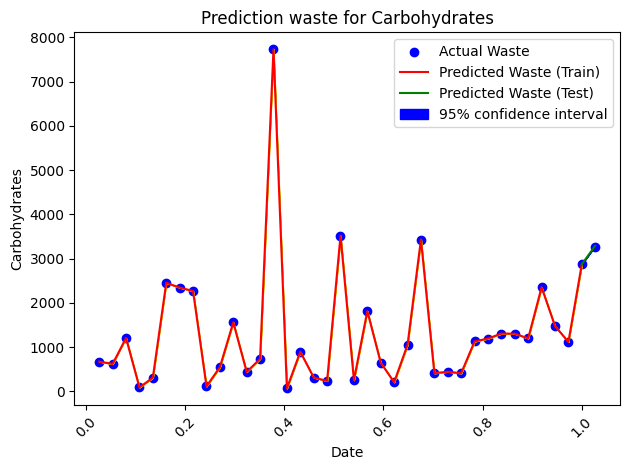

In [4]:
#Set the confidence interval (shah)
#w = 2
w = 1
alpha = 1 #0.2

# For plotting purposes
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_test = X_test.squeeze() 
y_test = y_test.squeeze()


# Visualization
plt.scatter(X, filtered_data[chosen_category],c='blue', label='Actual Waste')
#plt.scatter(filtered_data['Date'], filtered_data[chosen_category],c='blue', label='Actual Waste')
plt.plot(X_train, y_pred_train, 'r', label='Predicted Waste (Train)')
plt.plot(X_test, y_pred_test, c='green', markersize=8, label='Predicted Waste (Test)')
plt.fill_between(
    X_train,
    y_pred_train -   y_pred_train_std, 
    y_pred_train +   y_pred_train_std, 
    alpha=alpha, 
    color='y')
plt.fill_between(
    X_test,
    y_pred_test -  y_pred_test_std, 
    y_pred_test +  y_pred_test_std, 
    alpha=alpha,
    color='b',
    label=r"95% confidence interval")
plt.xlabel('Date')
plt.ylabel(chosen_category)
plt.title(f'Prediction waste for {chosen_category}')
plt.legend()
plt.xticks(rotation=45)
#plt.grid(True)
plt.tight_layout()
plt.show()